In [42]:
using AutomotiveSimulator
using AutomotiveVisualization
using EzXML

┌ Info: Precompiling EzXML [8f5d6c58-4d21-5cfd-889c-e3ad7ee6a615]
└ @ Base loading.jl:1260


In [34]:
# using AutoUrban
include("../src/roadway/roadway_generation.jl")
include("../src/roadway/roadway_perception.jl")
include("../src/roadway/roadway_intersection.jl")
include("../src/roadway/convert2xodr.jl")

convert_roadway! (generic function with 1 method)

In [35]:
using LinearAlgebra
using DelimitedFiles

## Build Roadway

In [36]:
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end


function get_new_angle(tangent_vector::Array{Float64})
    # it might be a problem when we switch quadrants
    # use signs of tangent vector to get the quadrant of the heading
    x = tangent_vector[1]
    y = tangent_vector[2]
    if x == 0. && y == 0.
        heading = 0.0
    elseif x == 0.
        heading = π/2 * sign(y)
    elseif y == 0.
        heading = convert(Float64, π) # this could be either pi or -pi, but just go with pi
    elseif sign(x) == 1 && sign(y) == 1 # first quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == 1 # second quadrant
        heading = atan(y, x)
    elseif sign(x) == 1 && sign(y) == -1 # fourth quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == -1 # third quadrant
        heading = atan(y, x)
    end
    # bound_heading doesn't end up getting called cause Julia takes care of it apparently
    bound_heading(heading)

    return heading
end


function bound_heading(heading::Float64)
    if heading > π # send this to be just near -pi
        heading = -π + (heading - π)    # if heading is 3.15, then the new angle will be (-pi + (3.15-pi)) = -3.13
    elseif heading < -π # send this to be just near pi
        heading = π + (heading + π)     # if heading is -3.15, then the new angle will be (pi + (-3.15+pi)) = 3.13
    end
    return heading
end


function append_headings(coordinates::Matrix{Float64})
    headings = ones(size(coordinates)[1])
    for i = 1:size(coordinates)[1]-1
        # need to make sure that math is right, and that bounds are kept
        tangent_vector = [coordinates[i+1,1]-coordinates[i,1], coordinates[i+1,2]-coordinates[i,2]]
        # @show tangent_vector
        current_heading = get_new_angle(tangent_vector)
        # @show current_heading
        headings[i] = current_heading
    end
    headings[end] = headings[end-1] # assume this is fine
    coordinates = hcat(coordinates, headings)
    return coordinates
end


function centerlines_txt2tracks(filename)
    coods = readdlm(filename,',')
    coods_app = append_headings(coods) # Append with the angle

    mid_coods = coods_app'

    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)

    nsamples = 20
    for i = 3:size(coods,1)
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, radius, radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

centerlines_txt2tracks (generic function with 1 method)

In [100]:
function make_roadway_interaction()
    road = Roadway()
        # Make segment 1: the on ramp a and first part of lane: b1
    track_a = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_a.txt")); # Top most on ramp
    lane_a = Lane(LaneTag(1,1),track_a,boundary_left=LaneBoundary(:broken,:white))

    track_b1 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_b1.txt")); # Top most on ramp
    lane_b1 = Lane(LaneTag(1,2),track_b1)

        # Make segment 2: second part of lane: b2. And connect both lanes of segment 1 into segment 2
    track_b2 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_b2.txt"))
    lane_b2 = Lane(LaneTag(2,1),track_b2)
    connect!(lane_a,lane_b2)
    connect!(lane_b1,lane_b2)

    push!(road.segments,RoadSegment(1,[lane_a, lane_b1]))
    push!(road.segments,RoadSegment(2,[lane_b2]))

        # Make segment 3: c and d
    track_c = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_c.txt"))
    lane_c = Lane(LaneTag(3,1),track_c,boundary_left=LaneBoundary(:broken,:white))

    track_d = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_d.txt"))
    lane_d = Lane(LaneTag(3,2),track_d)

    push!(road.segments,RoadSegment(3,[lane_c,lane_d]))

            # Other side of the divider
        # Make segment 4: g,f1,e1
    track_g = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_g.txt"))
    lane_g = Lane(LaneTag(4,1),track_g,boundary_left=LaneBoundary(:broken,:white))

    track_f1 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_f1.txt"))
    lane_f1 = Lane(LaneTag(4,2),track_f1,boundary_left=LaneBoundary(:broken,:white))

    track_e1 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_e1.txt"))
    lane_e1 = Lane(LaneTag(4,3),track_e1)

        # Make segment 5: f2,e2. And connect 3 lanes of segment 4 into segment 5 two lanes
    track_f2 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_f2.txt"))
    lane_f2 = Lane(LaneTag(5,1),track_f2,boundary_left=LaneBoundary(:broken,:white))

    track_e2 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_e2.txt"))
    lane_e2 = Lane(LaneTag(5,2),track_e2)
    connect!(lane_e1,lane_e2)
    connect!(lane_f1,lane_f2)
    connect!(lane_g,lane_f2)

    push!(road.segments,RoadSegment(4,[lane_g,lane_f1,lane_e1]))
    push!(road.segments,RoadSegment(5,[lane_f2,lane_e2]))

    return road
end

make_roadway_interaction (generic function with 1 method)

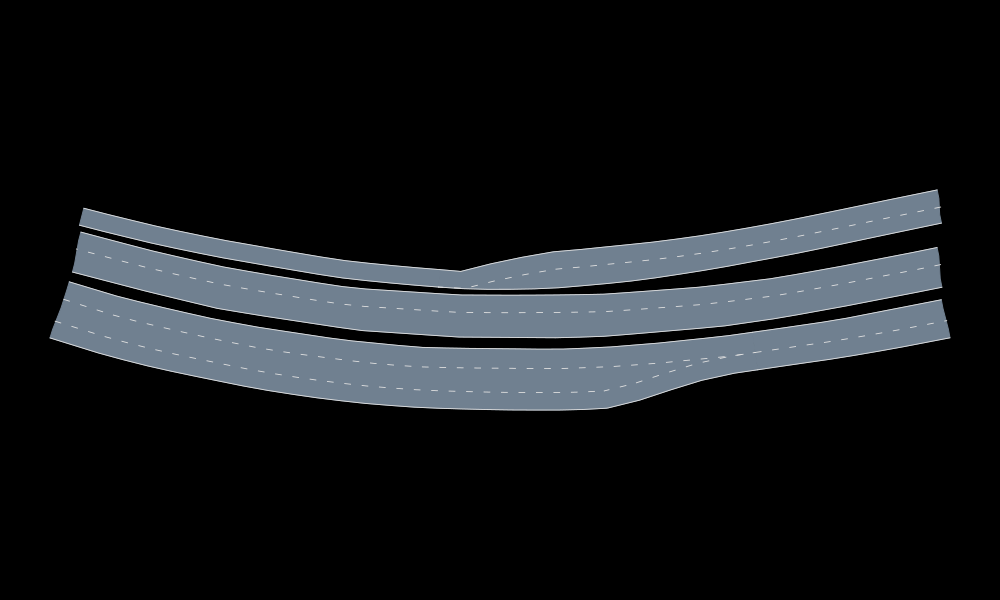

In [101]:
road = make_roadway_interaction()
render([road])

In [93]:
#Initialze
doc,r = initialize_XML()
#Convert roadway and ignoring any junctions
convert_roadway!(r,road)
prettyprint(doc)


<?xml version="1.0" encoding="UTF-8"?>
<OpenDRIVE>
  <header revMajor="1" revMinor="4" name="" version="1.00" data="Tue Mar 21 15:00:43 2017" north="0" south="0" east="0" west="0"></header>
  <road name="" id="1" length="83.01973989265717" junction="-1">
    <type s="0" type="rural"/>
    <link><successor elementType="road" elementId="2" contactPoint="start"/></link>
    <planView>
      <geometry s="0.0" x="1146.2697439050535" y="973.136231976754" hdg="3.343587454215944" length="83.01973989265717">
        <arc curvature="1.82184514383744e-7"/>
      </geometry>
    </planView>
    <lanes>
      <laneOffset s="0.0" a="1.5" b="0" c="0" d="0"/>
      <laneSection s="0">
        <left/>
        <center>
          <lane id="0" type="driving" level="false"><roadMark sOffset="0.0" type="solid" weight="standard" color="standard" width="0.5" laneChange="both"/></lane>
        </center>
        <right>
          <lane id="-1" type="driving" level="false">
            <width sOffset="0" a="3.0"

In [94]:
write("interaction.xodr",doc)


5470

## Build Sections 

In [95]:
function make_roadway_interaction_partial()
    road = Roadway()
        # Make segment 1: the on ramp a and first part of lane: b1
    track_a = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_a.txt")); # Top most on ramp
    lane_a = Lane(LaneTag(1,1),track_a,boundary_left=LaneBoundary(:broken,:white))

    track_b1 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_b1.txt")); # Top most on ramp
    lane_b1 = Lane(LaneTag(1,2),track_b1)

        # Make segment 2: second part of lane: b2. And connect both lanes of segment 1 into segment 2
    track_b2 = centerlines_txt2tracks(joinpath(@__DIR__,"../dataset/centerlines_b2.txt"))
    lane_b2 = Lane(LaneTag(2,1),track_b2)
#     connect!(lane_a,lane_b2)
#     connect!(lane_b1,lane_b2)

    push!(road.segments,RoadSegment(1,[lane_a]));  print("lane a\n");
    push!(road.segments,RoadSegment(2,[lane_b2])); print("lane b2\n");
    
    return road
end

make_roadway_interaction_partial (generic function with 1 method)

lane a
lane b2


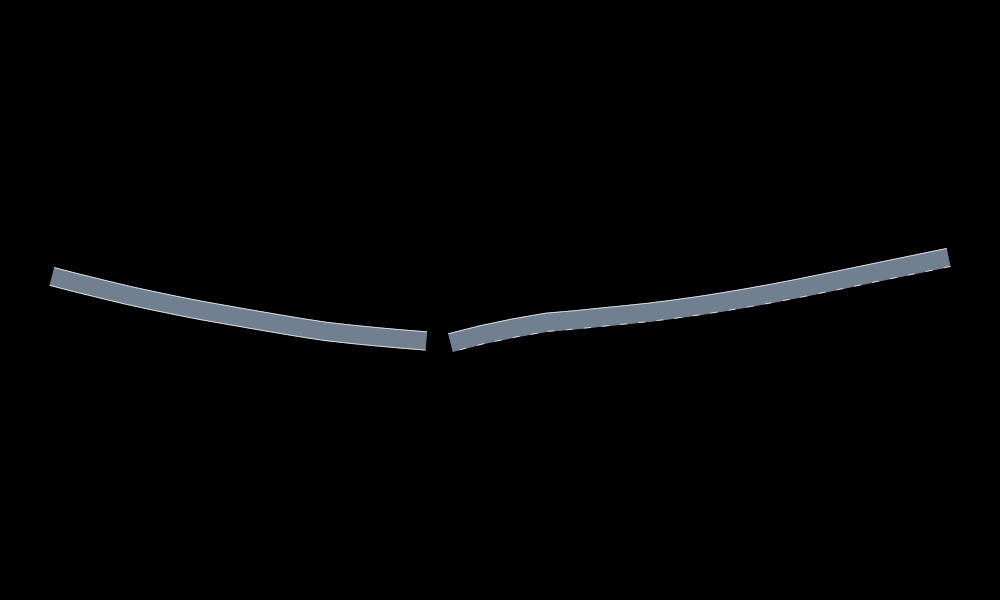

In [96]:
road_partial = make_roadway_interaction_partial()
render([road_partial])


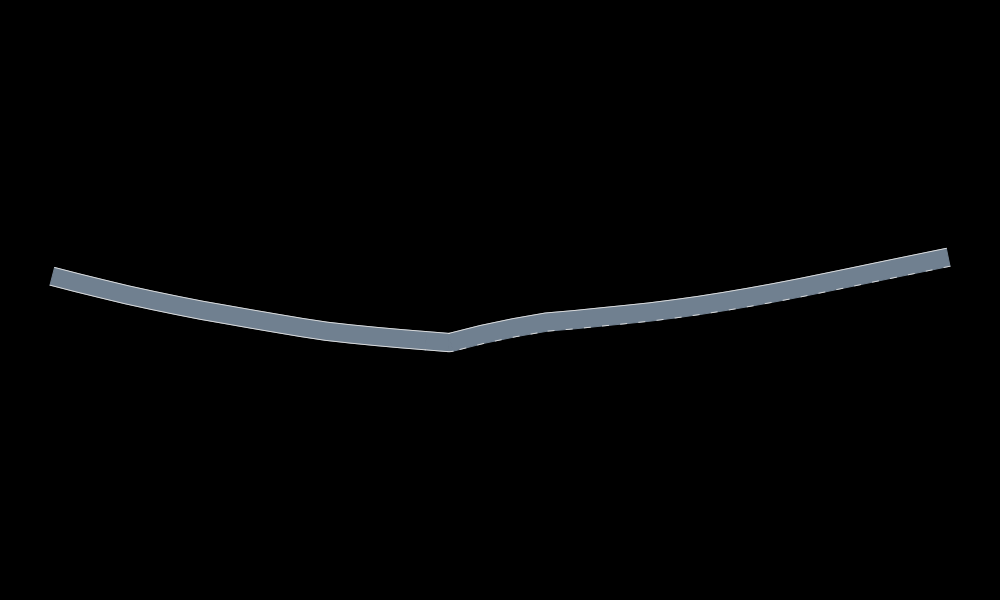

In [97]:
junctions = [Junction([Connection(1,2)])]

for junction in junctions
    add_junction!(junction, road_partial)
end
render([road_partial])


In [98]:
#Initialze
doc,r = initialize_XML()
#Convert roadway and ignoring any junctions
convert_roadway!(r,road_partial)
#Handle junctions
# junctions = [junction];
handle_junctions(r,junctions,road_partial)
prettyprint(doc)


<?xml version="1.0" encoding="UTF-8"?>
<OpenDRIVE>
  <header revMajor="1" revMinor="4" name="" version="1.00" data="Tue Mar 21 15:00:43 2017" north="0" south="0" east="0" west="0"></header>
  <road name="" id="1" length="83.01973989265717" junction="-1">
    <type s="0" type="rural"/>
    <link><successor elementType="junction" elementId="1"/></link>
    <planView>
      <geometry s="0.0" x="1146.2697439050535" y="973.136231976754" hdg="3.343587454215944" length="83.01973989265717">
        <arc curvature="1.82184514383744e-7"/>
      </geometry>
    </planView>
    <lanes>
      <laneOffset s="0.0" a="1.5" b="0" c="0" d="0"/>
      <laneSection s="0">
        <left/>
        <center>
          <lane id="0" type="driving" level="false"><roadMark sOffset="0.0" type="solid" weight="standard" color="standard" width="0.5" laneChange="both"/></lane>
        </center>
        <right>
          <lane id="-1" type="driving" level="false">
            <width sOffset="0" a="3.0" b="0.0" c="0.0" 

In [99]:
write("interaction_ab2.xodr",doc)


3959